# CNN Transfer Learning on Cats-Dogs Classification

### VGG16 trained on ImageNet data is used as pre-trained model from which to extract features.  Features are then saved, and passed through neural network with ReLu hidden layer to classify cats vs. dogs.

#### Adapted from fchollet/classifier_from_little_data_script_2.py (https://gist.github.com/fchollet/f35fbc80e066a49d65f1688a7e99f069) and blog https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

In [1]:
import keras

Using TensorFlow backend.


In [2]:
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout, Flatten, Dense
from keras import backend as K
from keras import applications
import numpy as np
import tensorflow as tf

In [3]:
print (tf.__version__)
print (keras.__version__)

1.14.0
2.2.4


In [4]:
# Set logging level
tf.logging.set_verbosity(tf.logging.ERROR)

In [5]:
# Set random generator seed
seed = 123

# Set python built-in random generator
import random                             
random.seed(seed)

# Set numpy random generator
np.random.seed(seed)

# Set tensorflow random generator
tf.random.set_random_seed(seed)

### Set dimensions, number, and location of images

In [6]:
# Image dimensions
img_width, img_height = 150, 150

# Location of images
train_data_dir = 'data/train'
validation_data_dir = 'data/validation'

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)
    
print (input_shape)

# Number of images
nb_train_samples = 2000
nb_validation_samples = 800

# Batch size
batch_size = 16

(150, 150, 3)


### Method to extract features from pre-trained network and save features

In [7]:
def save_features():
    
    # Scale pixel values in image
    datagen = ImageDataGenerator(rescale=1. / 255)

    # Load the VGG16 network's imagenet weights, not including the last fully connected layers.
    model = applications.VGG16(include_top=False, weights='imagenet')

    # Generator that will read pictures found in subfolders of training data directory,
    # and indefinitely generate batches of image data (scaled)
    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,        # Generator will only yield batches of data, no labels
        shuffle=False)          # Data will be presented in order, i.e., 1000 cat images, then 1000 dog images
    
    # The predict_generator method returns the output of the model, given input provided by a generator
    # that yields batches of numpy data
    features_train = model.predict_generator(
        generator, nb_train_samples // batch_size)
    
    # Save model outputs (i.e., features) from model as numpy array
    np.save('features_train.npy', features_train) 

    # Generator to generator validation input for model
    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    
    # Get model output for validation data
    features_validation = model.predict_generator(
        generator, nb_validation_samples // batch_size)
    
    # Save model outputs (i.e., features) for validation data
    np.save('features_validation.npy', features_validation) 
    
    # Print out model architecture
    model.summary()

In [8]:
save_features()

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
___________________________________________________________

### Load saved features

In [9]:
# Load saved features for train data
train_data = np.load('features_train.npy')
    
# Create labels for train data.  Images were generated in order, so creating labels is easy.
train_labels = np.array([0] * (nb_train_samples // 2) + [1] * (nb_train_samples // 2)) 

# Load saved features for validation data
validation_data = np.load('features_validation.npy') 
    
# Create labels for validation data
validation_labels = np.array([0] * (nb_validation_samples // 2) + [1] * (nb_validation_samples // 2)) 
    
print (train_labels.shape, validation_labels.shape)

(2000,) (800,)


### Create top model

In [10]:
# Create fully connected layer on top of model
top_model = Sequential()
top_model.add(Flatten(input_shape=train_data.shape[1:]))  # Convert 3D feature maps to 1D feature vectors
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

# Create model
top_model.compile(optimizer='rmsprop',
              loss='binary_crossentropy', 
              metrics=['accuracy'])
print(top_model)
top_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________


### Train top model

In [11]:
# Set up model
epochs = 50

# Train model, keeping track of history
from keras.callbacks import History
hist = top_model.fit(train_data, train_labels,
                 epochs=epochs,
                 batch_size=batch_size,
                 validation_data=(validation_data, validation_labels))

Train on 2000 samples, validate on 800 samples
Epoch 1/50
2000/2000 [==============================] - 1s 496us/step - loss: 0.6682 - acc: 0.7640 - val_loss: 0.4612 - val_acc: 0.7963
Epoch 2/50
2000/2000 [==============================] - 1s 289us/step - loss: 0.3741 - acc: 0.8520 - val_loss: 0.2527 - val_acc: 0.9000
Epoch 3/50
2000/2000 [==============================] - 1s 287us/step - loss: 0.2793 - acc: 0.8865 - val_loss: 0.6465 - val_acc: 0.7612
Epoch 4/50
2000/2000 [==============================] - 1s 285us/step - loss: 0.2752 - acc: 0.8925 - val_loss: 0.3668 - val_acc: 0.8550
Epoch 5/50
2000/2000 [==============================] - 1s 285us/step - loss: 0.2201 - acc: 0.9230 - val_loss: 0.2577 - val_acc: 0.8988
Epoch 6/50
2000/2000 [==============================] - 1s 286us/step - loss: 0.1996 - acc: 0.9240 - val_loss: 0.2825 - val_acc: 0.9038
Epoch 7/50
2000/2000 [==============================] - 1s 287us/step - loss: 0.1603 - acc: 0.9405 - val_loss: 0.3265 - val_acc: 0.8950
E

### Save model and weights

In [12]:
# Save model & weights to HDF5 file
top_model_file = 'features_model' 
top_model.save(top_model_file + '.h5')

# Save model to JSON file & weights to HDF5 file
top_model_json = top_model.to_json()
with open(top_model_file + '.json','w') as json_file:
    json_file.write(top_model_json)
top_model.save_weights(top_model_file+'-wts.h5')

# Results on validation set
print (top_model.metrics_names)
results = top_model.evaluate (validation_data, validation_labels)
print (results)

['loss', 'acc']
800/800 [==============================] - 0s 47us/step
[1.0752057370793773, 0.89125]


### Load model again and test

In [13]:
top_model2 = keras.models.load_model(top_model_file+'.h5')
print (validation_labels.shape)

print (top_model2.metrics_names)
results = top_model2.evaluate(validation_data, validation_labels)
print (results)

(800,)
['loss', 'acc']
800/800 [==============================] - 0s 115us/step
[1.0752057370793773, 0.89125]


### Print training history

In [14]:
print (hist.history)

{'val_loss': [0.46121483635157345, 0.2527155252173543, 0.6465335841127672, 0.36684080569073557, 0.25768382363021375, 0.2824503204133362, 0.3265056228544563, 0.2847060520760715, 0.3684620737377554, 0.476511753462255, 0.4385996869741939, 0.4906920578633435, 0.4290075692522805, 0.4851451185930637, 0.5683167743463128, 0.5479437365545892, 0.5363407289536554, 0.5747882935038069, 0.5088488167879405, 0.6431072643046718, 0.6288321653020467, 0.7306401976462769, 0.5733797401555785, 0.6250753047404578, 0.627068932181287, 0.7747057134602438, 0.76521593368504, 0.8796431314735788, 0.6868267187274978, 0.7519726292143969, 0.8423020712530888, 0.833870658127571, 0.7664608075119395, 0.8304027832638576, 0.9030322267045346, 0.8828460527482764, 0.828241996122888, 1.1027170819384589, 0.9192180459750483, 0.8946301585946455, 0.8893841055536745, 0.9676686582262919, 0.8872705064559141, 1.023587653291513, 0.9712612412010583, 1.0996841933556945, 0.9683264672734099, 0.9803338529772907, 0.935250818279506, 1.075205743

### Plot performance metrics

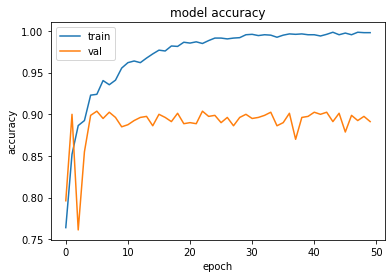

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

result = hist.history

# summarize history for accuracy
plt.plot(result['acc'])
plt.plot(result['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()